# Start-to-Finish Example: Numerical Solution of the Scalar Wave Equation, in Cartesian Coordinates

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## This module solves the scalar wave equation for a plane wave in Cartesian coordinates. To make the entire code immediately visible, the [`MoLtimestepping`](Tutorial-Method_of_Lines-C_Code_Generation.ipynb) module is not used here.

**Module Status:** <font color='green'><b>Validated</b></font>

**Validation Notes:** This module has been validated to converge at the expected order to the exact solution (see [plot](#convergence) at bottom).

### NRPy+ Source Code for this module: 
* [ScalarWave/ScalarWave_RHSs.py](../edit/ScalarWave/ScalarWave_RHSs.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) Generates the right-hand side for the Scalar Wave Equation in cartesian coordinates
* [ScalarWave/InitialData_PlaneWave.py](../edit/ScalarWave/InitialData_PlaneWave.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) Generating C code for plane wave initial data for the scalar wave equation

## Introduction:

As outlined in the [previous NRPy+ tutorial module](Tutorial-ScalarWave.ipynb), we first use NRPy+ to generate initial data for the scalar wave equation, and then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data.</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate scalar wave RHS expressions.</font>
    1. Apply boundary conditions.
1. At the end of each iteration in time, output the relative error between numerical and exact solutions.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This module is organized as follows

1. [Step 1](#generate):  Generating the NRPy+ Components to the Scalar Wave Equation in Three Spatial Dimensions, Fourth-Order Finite Differencing, with Monochromatic Plane Wave Initial Data
1. [Step 2](#mainc): `ScalarWave_Playground.c`: The Main C Code
1. [Step 3](#convergence): Code validation: Verify that relative error in numerical solution converges to zero at the expected order
1. [Step 4](#latex_pdf_output): Output this module to $\LaTeX$-formatted PDF file

<a id='generate'></a>

# Step 1: Generating the NRPy+ Components to the Scalar Wave Equation in Three Spatial Dimensions, Fourth-Order Finite Differencing, with Monochromatic Plane Wave Initial Data \[Back to [top](#toc)\]
$$\label{generate}$$

Let's pick up where we left off in the [previous module](Tutorial-ScalarWave.ipynb), interfacing with the [ScalarWave/InitialData_PlaneWave](../edit/ScalarWave/InitialData_PlaneWave.py) and [ScalarWave/ScalarWave_RHSs](../edit/ScalarWave/ScalarWave_RHSs.py) NRPy+ modules to generate
* monochromatic (single-wavelength) plane wave scalar wave initial data, and
* the scalar wave equation RHSs at **4th** finite difference order in **3 spatial dimensions**

In [1]:
# Step P1: Import needed NRPy+ core modules:
import NRPy_param_funcs as par
import indexedexp as ixp
import grid as gri
import finite_difference as fin
import loop as lp
from outputC import *

# Step 1: Import the ScalarWave.InitialData module. 
#         This command only declares ScalarWave initial data 
#         parameters and the InitialData_PlaneWave() function.
import ScalarWave.InitialData_PlaneWave as swid

# Step 2: Import ScalarWave_RHSs module. 
#         This command only declares ScalarWave RHS parameters
#         and the ScalarWave_RHSs function (called later)
import ScalarWave.ScalarWave_RHSs as swrhs

# Step 3: Set the spatial dimension parameter
#         to 3, and then read the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 4: Set the finite differencing order to 4.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",10)

# Step 5: Call the InitialData_PlaneWave() function to set up
#         monochromatic (single frequency/wavelength) scalar
#         wave initial data.
swid.InitialData_PlaneWave()

# Step 6: Generate SymPy symbolic expressions for
#         uu_rhs and vv_rhs; the ScalarWave RHSs.
#         This function also declares the uu and vv
#         gridfunctions, which need to be declared
#         to output even the initial data to C file.
swrhs.ScalarWave_RHSs()

# Generates declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes("./ScalarWave/")

# Step 7: Generate C code for the initial data,
#         output to a file named "SENR/ScalarWave_InitialData.h".
IDstring = fin.FD_outputC("returnstring",[lhrh(lhs="*uu_exact",rhs=swid.uu_ID),
                                          lhrh(lhs="*vv_exact",rhs=swid.vv_ID)])

with open("ScalarWave/ScalarWave_ExactSolution_single_point.h", "w") as file:
    file.write(IDstring)

with open("ScalarWave/ScalarWave_ExactSolution.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["0","0","0"],
                       ["Nxx_plus_2NGHOSTS2","Nxx_plus_2NGHOSTS1","Nxx_plus_2NGHOSTS0"],["1","1","1"],
                       ["#pragma omp parallel for","    const REAL xx2=xx[2][i2];",
                        "        const REAL xx1=xx[1][i1];"],"",
"""
const REAL xx0=xx[0][i0];
exact_solution_single_point(xx0,xx1,xx2,params,&in_gfs[IDX4S(UUGF,i0,i1,i2)],&in_gfs[IDX4S(VVGF,i0,i1,i2)]);
"""))


# Step 8: Generate C code for scalarwave RHSs,
#         output to a file named "SENR/ScalarWave_RHSs.h".
RHSstring = fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("rhs_gfs","uu"),rhs=swrhs.uu_rhs),
                                           lhrh(lhs=gri.gfaccess("rhs_gfs","vv"),rhs=swrhs.vv_rhs)],
                           params="SIMD_enable=True")

with open("ScalarWave/ScalarWave_RHSs-SIMD.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx2","NGHOSTS+Nxx1","NGHOSTS+Nxx0"],
                       ["1","1","SIMD_width"],
                       ["""
#pragma omp parallel for""","","""
"""],"",RHSstring.replace("IDX4","IDX4S")))

<a id='mainc'></a>

# Step 2: `ScalarWave_Playground.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$

Next we will write the C code infrastructure necessary to make use of the above NRPy+-generated codes. Again, we'll be using RK4 time integration via the Method of Lines.

In [2]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("ScalarWave/ScalarWave_NGHOSTS.h", "w") as file:
    file.write("// Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2))+"\n")

In [3]:
%%writefile ScalarWave/ScalarWave_Playground-SIMD.c

// Part P0: Import NGHOSTS, which is based on FD_CENTDERIVS_ORDER
#include "ScalarWave_NGHOSTS.h"
// Part P0a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

#include "declare_Cparameters_struct.h"

// All SIMD intrinsics used in SIMD-enabled C code loops are defined here:
#include "../SIMD/SIMD_intrinsics.h"

const int NSKIP_0D_OUTPUT = 1;
const int NSKIP_2D_OUTPUT = 10;

// Part P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"

// Part P2: Add needed #define's to set data type, the IDX4S() macro, and the gridfunctions
// Part P2a: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
// Part P2b: Set UUGF and VVGF macros
#define NUM_GFS 2
#define UUGF 0
#define VVGF 1

// Part P4: Declare the function for the exact solution. time==0 corresponds to the initial data.
inline void exact_solution_single_point(const REAL xx0,const REAL xx1,const REAL xx2,
                                        const paramstruct *restrict params,
                                        REAL *uu_exact, REAL *vv_exact) {
#include "set_Cparameters.h"
#include "ScalarWave_ExactSolution_single_point.h"
}
void exact_solution_all_points(const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict in_gfs) {
#include "set_Cparameters.h"
#include "ScalarWave_ExactSolution.h"
}

// Part P5: Declare the function to evaluate the scalar wave RHSs
void rhs_eval(const paramstruct *restrict params, const REAL *restrict in_gfs, REAL *restrict rhs_gfs) {
#include "set_Cparameters-SIMD.h"
#include "ScalarWave_RHSs-SIMD.h"
}

// Part P6: Declare boundary condition FACE_UPDATE macro,
//          which updates a single face of the 3D grid cube
//          using quadratic polynomial extrapolation.
const int MAXFACE = -1;
const int NUL     = +0;
const int MINFACE = +1;
#define  FACE_UPDATE(which_gf, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) { \
        gfs[IDX4S(which_gf,i0,i1,i2)] =                                  \
          +3.0*gfs[IDX4S(which_gf,i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]  \
          -3.0*gfs[IDX4S(which_gf,i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]  \
          +1.0*gfs[IDX4S(which_gf,i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)]; \
      }

// Part P7: Boundary condition driver routine: Apply BCs to all six
//          boundary faces of the cube, filling in the innermost
//          ghost zone first, and moving outward.
void apply_bcs(const paramstruct *restrict params,REAL *gfs) {
#pragma omp parallel for
    for(int which_gf=0;which_gf<NUM_GFS;which_gf++) {
#include "set_Cparameters.h"
        int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
        int imax[3] = { Nxx_plus_2NGHOSTS0-NGHOSTS, Nxx_plus_2NGHOSTS1-NGHOSTS, Nxx_plus_2NGHOSTS2-NGHOSTS };
        for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
            // After updating each face, adjust imin[] and imax[] 
            //   to reflect the newly-updated face extents.
            FACE_UPDATE(which_gf, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]--;
            FACE_UPDATE(which_gf, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]++;

            FACE_UPDATE(which_gf, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]--;
            FACE_UPDATE(which_gf, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]++;

            FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]--;
            FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]++;
        }
    }
}
// Part P8: 2D File output routine, for comparing numerical results to exact solution
void output_2D(const paramstruct *restrict params, const int iter, REAL *xx[3],
               const REAL *numerical_gridfunction_data,REAL *gridfunction_to_store_exact) {
#include "set_Cparameters.h"
    // Step 2a: Validation: Output to 2D data files numerical and exact solutions
    char filename[100];
    sprintf(filename,"out2D__resolution_%dx%dx%d__iter_%d.txt",Nxx0,Nxx1,Nxx2,iter);
    FILE *out2D = fopen(filename, "w");
    const int i2  = (int)((Nxx2+ 2*NGHOSTS)*0.5);
    const REAL xx2 = xx[2][i2];
    for(int i0=0;i0<Nxx0+2*NGHOSTS;i0++) {
        for(int i1=0;i1<Nxx1+2*NGHOSTS;i1++) {
            if(i0> (Nxx0+2*NGHOSTS)*.25 && i0< (Nxx0+2*NGHOSTS)*.75 &&
               i1> (Nxx1+2*NGHOSTS)*.25 && i1< (Nxx1+2*NGHOSTS)*.75) { 
                const REAL xx0 = xx[0][i0];
                const REAL xx1 = xx[1][i1];
                REAL uu_exact,vv_exact; exact_solution_single_point(xx0,xx1,xx2,params, &uu_exact,&vv_exact);
                fprintf(out2D,"%e %e %e %e\n", xx0,xx1,
                        numerical_gridfunction_data[IDX4S(0,i0,i1, (int)((Nxx2+ 2*NGHOSTS)*0.5))], uu_exact);
            }
        }
    }
    fclose(out2D);
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"
    // Step 0a: Read command-line input, error out if nonconformant
    if(argc != 2 || atoi(argv[1]) < NGHOSTS) {
      printf("Error: Expected one command-line argument: ./ScalarWave_Playground [Nx(=Ny=Nz)],\n");
      printf("where Nx is the number of grid points in the x,y, and z directions.\n");
      printf("Nx MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
      exit(1);
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nx0x1x2 = atoi(argv[1]);
    const int Nxx[3] = { Nx0x1x2, Nx0x1x2, Nx0x1x2 };
    const int Nxx_plus_2NGHOSTS0 = Nxx[0]+2*NGHOSTS;
    const int Nxx_plus_2NGHOSTS1 = Nxx[1]+2*NGHOSTS;
    const int Nxx_plus_2NGHOSTS2 = Nxx[2]+2*NGHOSTS;
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Set free-parameter values.
    params.time = 0.0;
    params.wavespeed = 1.0;
    params.kk0 = 1.0;
    params.kk1 = 1.0;
    params.kk2 = 1.0;

    // Override parameter defaults with values based on command line arguments and NGHOSTS.
    params.Nxx0 = Nxx[0];
    params.Nxx1 = Nxx[1];
    params.Nxx2 = Nxx[2];
    params.Nxx_plus_2NGHOSTS0 = Nxx_plus_2NGHOSTS0;
    params.Nxx_plus_2NGHOSTS1 = Nxx_plus_2NGHOSTS1;
    params.Nxx_plus_2NGHOSTS2 = Nxx_plus_2NGHOSTS2;
    
    const REAL xxmin[3] = {-10.,-10.,-10. };
    const REAL xxmax[3] = { 10., 10., 10. };
    //          ... and then set up the numerical grid structure in time:
    const REAL t_final = xxmax[0]*0.8; /* Final time is set so that at t=t_final, 
                                        data at the origin have not been corrupted 
                                        by the approximate outer boundary condition */
    const REAL CFL_FACTOR = 0.5; // Set the CFL Factor

    // Step 0c: Allocate memory for gridfunctions
    REAL *restrict evol_gfs    = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *restrict next_in_gfs = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *restrict k1_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *restrict k2_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *restrict k3_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *restrict k4_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0d: Set up coordinates: Set dx, and then dt based on dx_min and CFL condition
    #define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
    REAL dxx0 = (xxmax[0] - xxmin[0]) / ((REAL)Nxx[0]);
    REAL dxx1 = (xxmax[1] - xxmin[1]) / ((REAL)Nxx[1]);
    REAL dxx2 = (xxmax[2] - xxmin[2]) / ((REAL)Nxx[2]);
    params.dxx0 = dxx0;
    params.dxx1 = dxx1;
    params.dxx2 = dxx2;
    params.invdx0 = 1.0 / dxx0;
    params.invdx1 = 1.0 / dxx1;
    params.invdx2 = 1.0 / dxx2;
    
    REAL dt = CFL_FACTOR * MIN(dxx0,MIN(dxx1,dxx2)); // CFL condition
    int Nt = (int)(t_final / dt + 0.5); // The number of points in time.
                                        //Add 0.5 to account for C rounding down integers.

    // Step 0e: Set up cell-centered Cartesian coordinate grids
    REAL *xx[3];
    xx[0] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS0);
    xx[1] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS1);
    xx[2] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS2);
    for(int j=0;j<Nxx_plus_2NGHOSTS0;j++) xx[0][j] = xxmin[0] + (j-NGHOSTS)*dxx0;
    for(int j=0;j<Nxx_plus_2NGHOSTS1;j++) xx[1][j] = xxmin[1] + (j-NGHOSTS)*dxx1;
    for(int j=0;j<Nxx_plus_2NGHOSTS2;j++) xx[2][j] = xxmin[2] + (j-NGHOSTS)*dxx2;

    // Step 1: Set up initial data to be exact solution at time=0:
    params.time = 0.0; exact_solution_all_points(&params, xx, evol_gfs);

    for(int n=0;n<=Nt;n++) { // Main loop to progress forward in time.
        // Step 1a: Set current time to correct value & compute exact solution
        params.time = ((REAL)n)*dt;

        /* Step 2: Validation: Output relative error between numerical and exact solution, */
        // Step 2b: Output to 2D grid (region of x-y plane near origin) 
        //          every NSKIP_2D_OUTPUT iterations.
        if((n)%NSKIP_2D_OUTPUT ==0) {
            // Step 2a: Evaluate exact solution at current time, (n)*dt. Store to k1_gfs.
            output_2D(&params, n, xx, evol_gfs, k1_gfs);
        }

        if((n)%NSKIP_0D_OUTPUT ==0) {
            // Step 2c: Output relative error between exact & numerical at center of grid.
            const int i0mid=Nxx_plus_2NGHOSTS0/2;
            const int i1mid=Nxx_plus_2NGHOSTS1/2;
            const int i2mid=Nxx_plus_2NGHOSTS2/2;
            REAL uu_exact,vv_exact; exact_solution_single_point(xx[0][i0mid],xx[1][i1mid],xx[2][i2mid],&params, 
                                                                &uu_exact,&vv_exact);
                                                                 
            const REAL numerical = evol_gfs[IDX4S(0,i0mid,i1mid,i2mid)];
            const REAL relative_error = fabs((uu_exact-numerical)/uu_exact);
            printf("%e %e || %e %e %e: %e %e\n",params.time, log10(relative_error),
                   xx[0][i0mid],xx[1][i1mid],xx[2][i2mid], numerical,uu_exact);
        }
                            
        // Step 3: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
        //         applying quadratic extrapolation outer boundary conditions.
        /***************************************************/
        /* Implement RK4 for Method of Lines timestepping: */
        /***************************************************/
        /* -= RK4: Step 1 of 4 =- */
        /* First evaluate k1 = RHSs expression             */
        rhs_eval(&params, evol_gfs, k1_gfs);
        /* Next k1 -> k1*dt, and then set the input for    */
        /*    the next RHS eval call to y_n+k1/2           */
#pragma omp parallel for
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
            k1_gfs[i] *= dt;
            next_in_gfs[i] = evol_gfs[i] + k1_gfs[i]*0.5;
        }
        /* Finally, apply boundary conditions to           */
        /* next_in_gfs, so its data are set everywhere.    */
        apply_bcs(&params, next_in_gfs);

        /* -= RK4: Step 2 of 4 =- */
        rhs_eval(&params, next_in_gfs, k2_gfs);
#pragma omp parallel for
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
            k2_gfs[i] *= dt;
            next_in_gfs[i] = evol_gfs[i] + k2_gfs[i]*0.5;
        }
        apply_bcs(&params, next_in_gfs);

        /* -= RK4: Step 3 of 4 =- */
        rhs_eval(&params, next_in_gfs, k3_gfs);
#pragma omp parallel for
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
            k3_gfs[i] *= dt;
            next_in_gfs[i] = evol_gfs[i] + k3_gfs[i];
        }
        apply_bcs(&params, next_in_gfs);

        /* -= RK4: Step 4 of 4 =- */
        rhs_eval(&params, next_in_gfs, k4_gfs);

#pragma omp parallel for
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
            k4_gfs[i] *= dt;
            evol_gfs[i] += (1.0/6.0)*(k1_gfs[i] + 2.0*k2_gfs[i] + 2.0*k3_gfs[i] + k4_gfs[i]);
        }
        apply_bcs(&params, evol_gfs);
    } // End main loop to progress forward in time.

    // Step 4: Free all allocated memory
    free(k4_gfs);
    free(k3_gfs);
    free(k2_gfs);
    free(k1_gfs);
    free(next_in_gfs);
    free(evol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Overwriting ScalarWave/ScalarWave_Playground-SIMD.c


In [4]:
# !gcc -mavx256-split-unaligned-load -mavx256-split-unaligned-store -fsimd-cost-model=unlimited -Ofast -fopenmp -march=native ScalarWave/ScalarWave_Playground-SIMD.c -fopt-info-vec-optimized-missed -o ScalarWave_Playground-SIMD -lm 2>&1 |grep RHS
# !gcc -fsimd-cost-model=unlimited -Ofast -fopenmp -march=native ScalarWave/ScalarWave_Playground-SIMD.c -fopt-info-vec-optimized-missed -o ScalarWave_Playground-SIMD -lm 2>&1 |grep RHS
# !gcc -Ofast -fopenmp -march=native ScalarWave/ScalarWave_Playground-SIMD.c -fopt-info-vec-optimized-missed -o ScalarWave_Playground-SIMD -lm 2>&1 |grep RHS
# Intel compiler command, requesting assembler output with useful comments.
#!icc -S -g -align -qopenmp -xHost -O2 -qopt-report=5 -qopt-report-phase ipo -qopt-report-phase vec -vec-threshold1 -qopt-prefetch=4 ScalarWave/ScalarWave_Playground-SIMD.c 

#!gcc -fsimd-cost-model=unlimited -Ofast -fopenmp -march=native ScalarWave/ScalarWave_Playground.c -fopt-info-vec-optimized-missed -o ScalarWave_Playground -lm 2>&1 |grep -A5 RHS

In [8]:
import cmdline_helper as cmd

cmd.C_compile("ScalarWave/ScalarWave_Playground-SIMD.c", "ScalarWave_Playground-SIMD")
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("out*.png")
#!icc -align -qopenmp -xHost -O2 -qopt-report=5 -qopt-report-phase ipo -qopt-report-phase vec -vec-threshold1 -qopt-prefetch=4 ScalarWave/ScalarWave_Playground-SIMD.c -o ScalarWave_Playground-SIMD

# 10o FD testing:
# 4.46s
# !icc -align -qopenmp -xHost -O2 -qopt-report=5 -qopt-report-phase ipo -qopt-report-phase vec -vec-threshold1 -qopt-prefetch=4 ScalarWave/ScalarWave_Playground-SIMD.c -o ScalarWave_Playground-SIMD
# 4.65s
# !gcc -Ofast -fopenmp -march=native ScalarWave/ScalarWave_Playground-SIMD.c -fopt-info-vec-optimized-missed -o ScalarWave_Playground-SIMD -lm 2>&1 |grep RHS
# 5.45s
# !clang -Ofast -fopenmp -mavx2 -mfma ScalarWave/ScalarWave_Playground-SIMD.c -o ScalarWave_Playground-SIMD -lm

cmd.Execute("ScalarWave_Playground-SIMD", "48", "out48.txt")
cmd.Execute("ScalarWave_Playground-SIMD", "64", "out64.txt")
cmd.Execute("ScalarWave_Playground-SIMD", "96", "out96.txt")

Compiling executable...
Executing `gcc -Ofast -fopenmp -march=native ScalarWave/ScalarWave_Playground-SIMD.c -o ScalarWave_Playground-SIMD -lm`...
Finished executing in 0.825771093369 seconds.
Finished compilation.
Executing `taskset -c 0,1 ./ScalarWave_Playground-SIMD 48`...
Finished executing in 0.42643404007 seconds.
Executing `taskset -c 0,1 ./ScalarWave_Playground-SIMD 64`...
Finished executing in 1.03649902344 seconds.
Executing `taskset -c 0,1 ./ScalarWave_Playground-SIMD 96`...
Finished executing in 4.65628790855 seconds.


<a id='convergence'></a>

# Step 3: Code Validation: Verify that relative error in numerical solution converges to zero at the expected order \[Back to [top](#toc)\]
$$\label{convergence}$$

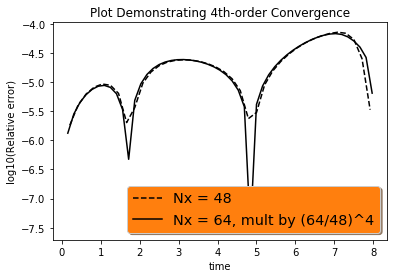

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpmath as mp
import csv

def file_reader(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=" ")
        data  = list(zip(*reader))
        # data is a tuple of strings. Tuples are immutable, and we need to perform math on
        #   the data, so here we convert tuple to lists of floats:
        data0 = []
        data1 = []
        for i in range(len(data[0])):
            data0.append(float(data[0][i]))
            data1.append(float(data[1][i]))
        return data0,data1
    
first_col48,second_col48 = file_reader('out48.txt')
first_col64,second_col64 = file_reader('out64.txt')

for i in range(len(second_col64)):
    # data64 = data48*(64/48)**4 
    # -> log10(data64) = log10(data48) + 4*log(64/48)
    second_col64[i] += 4*mp.log10(64./48.)

# https://matplotlib.org/gallery/text_labels_and_annotations/legend.html#sphx-glr-gallery-text-labels-and-annotations-legend-py        
fig, ax = plt.subplots()

plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("time")
plt.ylabel("log10(Relative error)")

ax.plot(first_col48, second_col48, 'k--', label='Nx = 48')
ax.plot(first_col64, second_col64, 'k-', label='Nx = 64, mult by (64/48)^4')
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 4: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-ScalarWave.pdf](Tutorial-Start_to_Finish-ScalarWave.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [7]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx Tutorial-Start_to_Finish-ScalarWave.ipynb
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWave.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWave.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWave.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-Start_to_Finish-ScalarWave.ipynb to latex
[NbConvertApp] Support files will be in Tutorial-Start_to_Finish-ScalarWave_files/
[NbConvertApp] Making directory Tutorial-Start_to_Finish-ScalarWave_files
[NbConvertApp] Writing 58308 bytes to Tutorial-Start_to_Finish-ScalarWave.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
